# Election data 2021 mining

In [48]:
import pandas as pd
import requests
import pathlib
import geopandas
import collections

In [49]:
districts_data = pd.read_csv("https://www.volby.cz/opendata/ps2021/csv_od/pst4_csv_od.zip", index_col="ID_OKRSKY")

In [50]:
DATA_DIR = pathlib.Path("./data")
DISTRICTS_FILE = "pst4_csv_od.zip"
DISTRCT_VOTES_FILE = "pst4p_csv_od.zip"
CANDIDATE_REGISTER_FILE = "psrkl.zip"
DISTRICTS_GEOJSON = "vol_okrsky_2022g100.geojson"
DISTRICTS_REG = "UI_VOLEBNI_OKRSEK.zip"

def _download_data():
    DATA_DIR.mkdir(exist_ok=True)
    if not (DATA_DIR / DISTRICTS_FILE).exists():
        response = requests.get(
            f"https://www.volby.cz/opendata/ps2021/csv_od/{DISTRICTS_FILE}",
            allow_redirects=True,
        )
        with open(DATA_DIR / DISTRICTS_FILE, mode="wb") as data_file:
            data_file.write(response.content)

    if not (DATA_DIR / DISTRCT_VOTES_FILE).exists():
        response = requests.get(
            f"https://www.volby.cz/opendata/ps2021/csv_od/{DISTRCT_VOTES_FILE}",
            allow_redirects=True,
        )
        with open(DATA_DIR / DISTRCT_VOTES_FILE, mode="wb") as data_file:
            data_file.write(response.content)
    if not (DATA_DIR / CANDIDATE_REGISTER_FILE).exists():
        response = requests.get(
            f"https://www.volby.cz/opendata/ps2021/csv_od/{CANDIDATE_REGISTER_FILE}",
            allow_redirects=True,
        )
        with open(DATA_DIR / CANDIDATE_REGISTER_FILE, mode="wb") as data_file:
            data_file.write(response.content)
    if not (DATA_DIR / DISTRICTS_GEOJSON).exists():
        response = requests.get(
            "https://www.volby.cz/opendata/se2022/geo/vol_okrsky_2022g100.geojson",
            allow_redirects=True,
        )
        with open(DATA_DIR / DISTRICTS_GEOJSON, mode="wb") as data_file:
            data_file.write(response.content)

    if not (DATA_DIR / DISTRICTS_REG).exists():
        response = requests.get(
            "https://www.cuzk.cz/CUZK/media/CiselnikyISUI/UI_VOLEBNI_OKRSEK/UI_VOLEBNI_OKRSEK.zip",
            allow_redirects=True,
        )
        with open(DATA_DIR / DISTRICTS_REG, mode="wb") as data_file:
            data_file.write(response.content)


def get_data(cutoff_percentage=3):
    """
        Function returning election data from CSU, parsed and filtered for usage in MachineLearning

    Args:
        cutoff_percentage (int, optional): What percentage of votes must a party gain to be considered relevant. Defaults to 3.

    Returns:
        pd.DataFrame: Dataframe with percentages of votes for each relevant party (and aggregated others) in each electoral district
    """
    _download_data()
    dtypes = {
        'OBEC': 'object',
        'OKRSEK':'object',
        'KSTRANA':'object',
        'VOL_SEZNAM':'float',
        'PL_HL_CELK':'float',
        'POC_HLASU':'float'

    }
    districts_data = pd.read_csv(
        DATA_DIR / DISTRICTS_FILE,
        index_col=["OBEC", "OKRSEK"],
        usecols=["OBEC", "OKRSEK", "VOL_SEZNAM", "PL_HL_CELK"],
        dtype= dtypes
    )
    district_votes_data = (
        pd.read_csv(
            DATA_DIR / DISTRCT_VOTES_FILE,
            index_col=["OBEC", "OKRSEK"],
            usecols=["OBEC", "OKRSEK", "KSTRANA", "POC_HLASU"],
            dtype=dtypes
        )
        .pivot(columns=["KSTRANA"])
        .fillna(0)
    )
    district_votes_data.columns = district_votes_data.columns.get_level_values(1)
    results = district_votes_data.sum() / districts_data["PL_HL_CELK"].sum()
    relevant_party_votes = district_votes_data[
        results.index[results > cutoff_percentage / 100]
    ]
    other_votes = district_votes_data[
        results.index[~(results > cutoff_percentage / 100)]
    ].sum(axis="columns")
    relevant_party_votes.loc[:, 0] = other_votes
    relevant_party_results = relevant_party_votes.div(
        districts_data["PL_HL_CELK"], axis=0
    )
    relevant_party_results.columns = [
        f"VYSL_{p}" for p in relevant_party_results.columns
    ]
    complete_dataset = districts_data.join(relevant_party_results)
    complete_dataset["VOL_UCAST"] = (
        complete_dataset["PL_HL_CELK"] / complete_dataset["VOL_SEZNAM"]
    )
    complete_dataset = complete_dataset.drop(
        ["VOL_SEZNAM", "PL_HL_CELK"], axis="columns"
    )
    return complete_dataset

def get_districts_frame():
    _download_data()
    geodf = geopandas.read_file(DATA_DIR/DISTRICTS_GEOJSON, dtype='object')
    geodf = geodf.set_index('KOD')
    geodf = geodf.drop(['CISLO','OBEC','MOMC','PLATIOD','PLATIDO'], axis='columns')

    reg = pd.read_csv(DATA_DIR/DISTRICTS_REG, encoding='iso-8859-15', delimiter=';', usecols=['OBEC_KOD','KOD','CISLO'], index_col=['KOD'], dtype='object')
    reg.index = reg.index.astype('str')
    districts_coords = geodf.join(reg, how='inner')
    districts_coords = districts_coords.set_index(['OBEC_KOD','CISLO'])
    districts_coords.index = districts_coords.index.rename(['OBEC','OKRSEK'])
    return districts_coords


In [51]:
results = get_data()

/tmp/ipykernel_2253/2346057261.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_party_votes.loc[:, 0] = other_votes


In [52]:
results

VYSL_12   VYSL_13   VYSL_17   VYSL_18   VYSL_20    VYSL_4   
OBEC   OKRSEK                                                               
500011 1       0.037698  0.279762  0.126984  0.027778  0.253968  0.132937  \
       2       0.045775  0.292254  0.130282  0.014085  0.264085  0.109155   
       3       0.031142  0.408304  0.128028  0.020761  0.207612  0.058824   
500020 1       0.088050  0.201258  0.138365  0.081761  0.220126  0.100629   
       2       0.042035  0.250000  0.081858  0.015487  0.307522  0.179204   
...                 ...       ...       ...       ...       ...       ...   
999997 107     0.000000  0.375000  0.541667  0.000000  0.000000  0.000000   
       108     0.263158  0.298246  0.105263  0.000000  0.070175  0.052632   
       109     0.200000  0.160000  0.120000  0.000000  0.440000  0.000000   
       110     0.000000  0.360000  0.440000  0.000000  0.000000  0.040000   
       111     0.025641  0.294872  0.440171  0.008547  0.021368  0.089744   

                 VYSL_5    VYSL_0  VOL_UCAST  
OBEC   OKRSEK                                 
500011 1       0.055556  0.085317   0.702929  
       2       0.056338  0.088028   0.652874  
       3       0.083045  0.062284   0.733503  
500020 1       0.050314  0.119497   0.593284  
       2       0.050885  0.073009   0.620027  
...                 ...       ...        ...  
999997 107     0.000000  0.083333   0.750000  
       108     0.017544  0.192982   0.791667  
       109     0.040000  0.040000   1.000000  
       110     0.040000  0.120000   0.362319  
       111     0.004274  0.115385   0.411972  

[14886 rows x 9 columns]

# Clustering

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [54]:
features = ['VYSL_4', 'VYSL_5', 'VYSL_12', 'VYSL_13', 'VYSL_17', 'VYSL_18', 'VYSL_20', 'VYSL_0']

/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/vscode/.local/lib/python3.

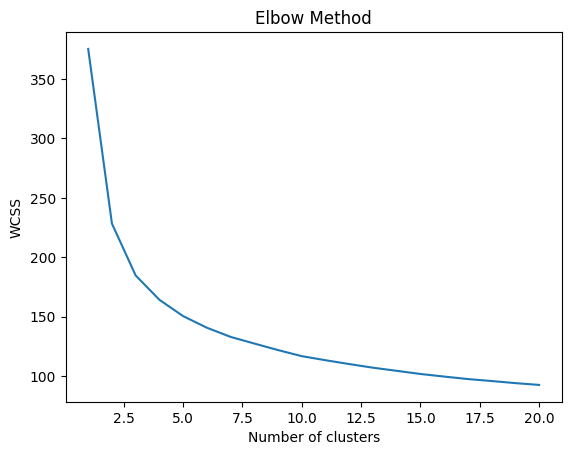

In [55]:
MAX_CLUSTERS = 20

# Compute the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for k in range(1, MAX_CLUSTERS + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(results[features])
    wcss.append(kmeans.inertia_)

# Plot the WCSS as a function of the number of clusters
plt.plot(range(1, MAX_CLUSTERS + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [56]:
CLUSTERS = 10

kmeans = KMeans(n_clusters=CLUSTERS)
kmeans.fit(results[features])
results['cluster'] = kmeans.labels_
print(results.groupby('cluster')[features].mean())

/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


           VYSL_4    VYSL_5   VYSL_12   VYSL_13   VYSL_17   VYSL_18   VYSL_20   
cluster                                                                         
0        0.168712  0.048270  0.048337  0.146452  0.105371  0.053683  0.351138  \
1        0.077429  0.047578  0.044818  0.386362  0.133473  0.032072  0.211903   
2        0.146178  0.056706  0.058257  0.221525  0.119699  0.053298  0.255101   
3        0.099707  0.051936  0.049573  0.221062  0.115747  0.045836  0.345784   
4        0.090302  0.052357  0.050051  0.292067  0.129795  0.038463  0.277038   
5        0.093242  0.050424  0.046455  0.196563  0.217323  0.040940  0.284145   
6        0.114475  0.047238  0.043104  0.137262  0.090343  0.050118  0.452737   
7        0.036851  0.028162  0.021817  0.288255  0.479735  0.007953  0.072805   
8        0.045797  0.033191  0.030902  0.424899  0.249179  0.016636  0.141611   
9        0.078428  0.045454  0.045283  0.310919  0.204765  0.030979  0.214787   

           VYSL_0  
cluster

In [57]:
_download_data()

In [135]:
geodf = geopandas.read_file(DATA_DIR/DISTRICTS_GEOJSON, dtype='object')
geodf = geodf.set_index('KOD')
geodf = geodf.drop(['CISLO','OBEC','MOMC','PLATIOD','PLATIDO'], axis='columns')

reg = pd.read_csv(DATA_DIR/DISTRICTS_REG, encoding='iso-8859-15', delimiter=';', usecols=['OBEC_KOD','KOD','CISLO'], index_col=['KOD'], dtype='object')
reg.index = reg.index.astype('str')
districts_coords = geodf.join(reg, how='inner')
districts_coords = districts_coords.set_index(['OBEC_KOD','CISLO'])
districts_coords.index = districts_coords.index.rename(['OBEC','OKRSEK'])

<Axes: >

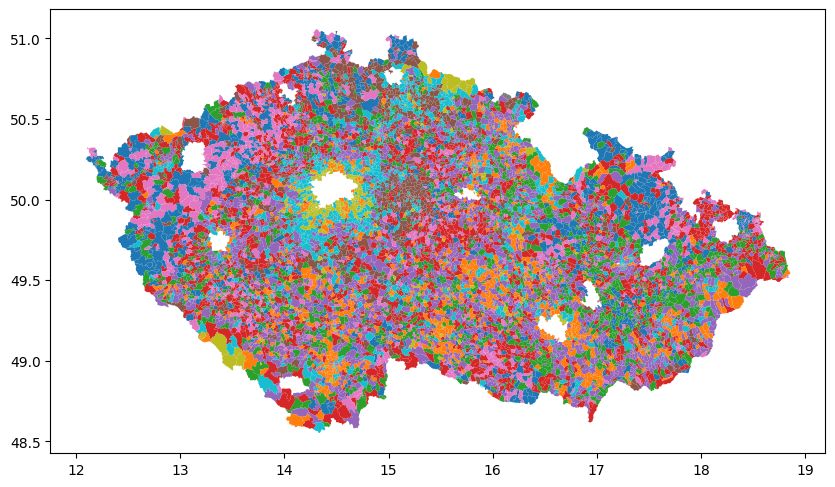

In [140]:

districts_coords.join(results.cluster).plot('cluster', categorical=True, figsize = (10,13))